<div class="markdown-google-sans">
  <h1>Avalanche Block and Transaction Performance</h1>
</div>

This notebook analyzes Avalanche network's block performance and transaction performance. It further uses a Logistic Regression to predict the transaction status of `SUCCESS` and `FAIL` using the transaction level data from the Flipside database.

The findings from the analysis are summarised below:

1. **Block Time:** During the period between 2022-06-20 (block `16259911`) and 2022-06-25 (block `16511800`), the following are observed:
- The time between blocks concentrates mostly in the range between 1 second to 5 seconds. 
- The average block time is 2 seconds.
- 88% of the blocks experienced less than or equal to 2 seconds between each block

2. **TPS:** The average TPS by hour fluctuates around 3.2 transactions. The minimum TPS is 2 transactions whereas the maximum is around 7.3 transactions.

3. **TX per Block:** The average transaction per block is around 5.7 transactions. The minimum transaction per block is 1 whereas the maximum is 144 transactions.

4. **TX vs. Gas Used:** The average number of transactions is highly correlated with the average gas used (75%).

5. **Gas Price:** The average gas price is 36.8; the minimum gas price is 25 and the maximum gas price is 13309. The average gas price for successful transactions is lower than the failed ones.

6. **TX Fees:** The average tx fee is 0.007; the minimum and the maximum tx fees are 0.0005 and 4.5 respectively. The average tx fee for successful transactions is slightly higher than the failed ones.

7. **TX Status:** More than 90% of the transactions on Avalanche are successful. 87% of the total gas is used for successful transactions and 85% of the fees paid are for successful transactions. There seems to be very little gas and fees wasted on failed transactions on Avalanche.

8. **TX Event:** `Transfer` constitutes the most event types in a transaction with 47% of the total transactions, followed by `Approval` (12%), `Sync` (11%) and `Swap` (10%). 80% of the transactions belong to these four event types.

9. **TX Status Prediction:**Logistic Regression predicts the `SUCCESS` and `FAIL` transaction with only 52% accuracy, with a large percentage of mis-classifying successful transactions into failed ones. The R-squared is also quite low – 16.85%. The four variables available and used in the model are far from enough to predict the transaction status. More additional variables containing more information will be needed to improve the prediction.


In [ ]:
#!pip install woeBinningPandas
import os
import re
import json
import requests
import numpy as np
import pandas as pd
import urllib.request
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from IPython.display import IFrame
import statistics
import seaborn as sns
from scipy.stats import pearsonr
import woeBinningPandas
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score, balanced_accuracy_score, precision_recall_fscore_support, log_loss, precision_score, f1_score, confusion_matrix, classification_report, mean_squared_error
from sklearn.model_selection import KFold


def clean_colnames(df):
	names = [ x.lower() for x in df.columns ]
	df.columns = names
	return df

def load_data(api):
    response = requests.get(api)
    data = pd.DataFrame(response.json())
    data = clean_colnames(data)
    return data

def load_data_multiple(api_list):
    for i in range(len(api_list)):
        if i==0:
            result = load_data(api_list[i])
        else:
            data = load_data(api_list[i])
            result = pd.concat([result, data], axis=0)
    result = result.drop_duplicates(keep=False)
    return result

def subplot_multiple(data, row, col, row_size, col_size, day_interval, item_list, title):
    fig, ax = plt.subplots(row, col, figsize=(row_size, col_size), constrained_layout=True)
    fig.suptitle(title, size=20)
    for i in range(row):
        for j in range(col):
            ax[i,j].plot('timestamp_h', item_list[i][j], data=data)
            #ax[i,j].xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=1, interval=day_interval))
            ax[i,j].xaxis.set_major_locator(ticker.LinearLocator(24))
            ax[i,j].tick_params(labelrotation=45)
            ax[i,j].set_ylabel(item[i][j])

def cdf_plot(data, groupby, title):
    ## Cumulative distribution
    agg = pd.DataFrame(data.groupby(groupby).size()).reset_index().rename(columns={0:"count"})
    agg['count_perc'] = agg['count']/agg['count'].sum()
    agg['cum_count'] = agg['count'].cumsum()
    agg['cum_count_perc'] = agg['cum_count']/agg['count'].sum()

    plt.plot(agg[groupby], agg['cum_count_perc'])
    plt.xlabel(groupby)
    plt.ylabel("cumulative percentage")
    plt.title(title)
    plt.show()

    return agg

def get_confusion_matrix(cm, classes=None, title = 'Confusion Matrix'):
    if classes is not None:
        ax = sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmin=0., vmax=100., annot=True, cmap='Blues')
        bottom, top = ax.get_ylim()
        ax.set_ylim(bottom+0.5, top-0.5)
        for t in ax.texts: t.set_text(t.get_text()+"%")
    
    else:
        ax = sns.heatmap(cm, vmin=0., vmax=100., cmap='Blues')
        bottom, top = ax.get_ylim()
        ax.set_ylim(bottom+1.5, top-1.5)
        for t in ax.texts: t.set_text(t.get_text()+"%")
        plt.title(title)
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

def plot_confusion_matrix(y, y_hat, class_name, title):
    cm_train = confusion_matrix(y, y_hat)
    cm_norm_train = cm_train/cm_train.sum(axis=1)[:, np.newaxis]
    plt.figure()
    get_confusion_matrix(cm_norm_train*100, classes=class_name)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    ax = plt.gca()
    ax.axes.get_xaxis().set_ticks([])

def model_performance(y, y_hat):
    print('Balanced Accuracy Score: ', np.round(balanced_accuracy_score(y, y_hat),2))
    print('Log Loss: ', np.round(log_loss(y, y_hat),2))
    out = precision_recall_fscore_support(y, y_hat, average='weighted')
    print('Precision: ', np.round(out[0],2))
    print('Recall: ', np.round(out[1],2))
    print('F-score: ', np.round(out[2],2))


<div class="markdown-google-sans">

## 1. Block Analysis
</div>

The block data used in this analysis is from 2022-06-20 (block number `16259911`) to 2022-06-25 (block number `16511800`). It is generated by paging through 100,000 data a time since this is the maximum rows the Flipside SQL interface allows. In this case, there are more than 200,000 rows for the period stated above, so the three datasets are generated from the Flipside SQL API and combined together.

The block time (`block_second`) is calculated by taking the timestamp difference between each block. Block numbers are increased by 1 for each block. However, this is not the case from the `avalanche.core.fact_blocks` table since it only contains external contract data. There are some block numbers missing (i.e. block_number_diff > 1), which belong to internal contract calls from `avalanche.core.fact_traces` table from the Flipside database.

For example, block number `16459633` shows the last block number is 22 increments away from it, i.e. 22 block numbers `16459612` to `16459632` are from the internal contract call database. Because of these missing blocks in the `fact_blocks` data table, the block time calculated between this block `16459633` and the previous block `16459611` available in the database will be much larger than normal.

In [ ]:
## Load block data from 'avalanche.core.fact_blocks'
api_list = ['https://node-api.flipsidecrypto.com/api/v2/queries/92d47db6-3b88-42ac-ba5e-155b97db486a/data/latest',
            'https://node-api.flipsidecrypto.com/api/v2/queries/c0358f6e-98a6-444b-9683-9c0263b0d539/data/latest',
            'https://node-api.flipsidecrypto.com/api/v2/queries/252137a3-c455-4181-a639-9d0ad473c2c8/data/latest']

block = load_data_multiple(api_list)

## Identify missing block number (internal contract calls)
missing_block = block[block['block_number_diff']>1]
print("Some examples of missing block numbers are:")
missing_block.head(5)

Some examples of missing block numbers are:


,block_number,block_timestamp,timestamp_h,tx_count,difficulty,gas_limit,gas_used,size,block_second,block_number_diff
99475,16459387,2022-06-24 14:46:33.000,2022-06-24 14:00:00.000,10,1,8000000,2523768,3969,2.0,2.0
99598,16459511,2022-06-24 14:50:48.000,2022-06-24 14:00:00.000,7,1,8000000,720351,2225,4.0,2.0
99615,16459529,2022-06-24 14:51:24.000,2022-06-24 14:00:00.000,3,1,8000000,183129,1458,4.0,2.0
99698,16459633,2022-06-24 14:54:52.000,2022-06-24 14:00:00.000,4,1,8000000,1385688,4887,44.0,22.0
99757,16459717,2022-06-24 14:57:40.000,2022-06-24 14:00:00.000,3,1,8000000,152344,1387,52.0,26.0



To account for this issue and purely focus on the external contract data for this analysis, the block time calculation is adjusted to be `block_second_adj = timstamp difference between each block / block_number_diff`. This assumes the block time between the current block and the next block that contains the external contract data is evenly distributed and allocated to the blocks inbetween that contains the internal contract data.

During the period between 2022-06-20 and 2022-06-25, the time between blocks concentrates in the range between 1 second to 5 seconds. The average block time is 2 seconds; while the maximum block time observed during the same period is 10 seconds. The minimum block time 0 second shown here could be a rounding number for block time less than 1 second. Since millisecond data is not available, the minimum is shown as 0 second.

The average block time is:  1.999383052155888  seconds.
The minimum block time is: 0.0  seconds.
The maximum block time is: 10.0  seconds.


Text(0.5, 0, 'Block number')

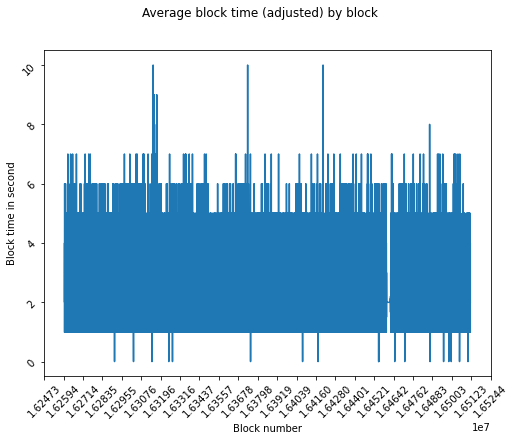

In [ ]:
## Adjust block time to consider missing blocks
block['block_second_adj'] = block['block_second'] / block['block_number_diff']

print("The average block time is: ", block['block_second_adj'].mean(), " seconds.")
print("The minimum block time is:", block['block_second_adj'].min(), " seconds.")
print("The maximum block time is:", block['block_second_adj'].max(), " seconds.")

## Plot block time 
fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.plot('block_number', 'block_second_adj', data=block)
fig.suptitle('Average block time (adjusted) by block')
ax.xaxis.set_major_locator(ticker.LinearLocator(24))
ax.tick_params(labelrotation=45)
ax.set_ylabel('Block time in second')
ax.set_xlabel('Block number')

The probability density function (PDF) plot shows the majority of the block time concentrates in 2 seconds. The cumulative distribution function (CDF) plot shows 88% of the blocks between block `16259911` and `16511800` experienced less than or equal to 2 seconds between each block.

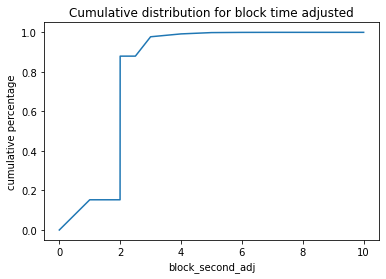

   block_second_adj   count  count_perc  cum_count  cum_count_perc
0          0.000000      18    0.000072         18        0.000072
1          1.000000   38100    0.152898      38118        0.152970
2          1.500000       3    0.000012      38121        0.152982
3          1.666667       1    0.000004      38122        0.152986
4          1.750000       1    0.000004      38123        0.152990
5          1.800000       1    0.000004      38124        0.152994
6          1.996751       1    0.000004      38125        0.152998
7          2.000000  181051    0.726570     219176        0.879568
8          2.021382       1    0.000004     219177        0.879572
9          2.130435       1    0.000004     219178        0.879576


Text(0.5, 1.0, 'Probability density for block time adjusted')

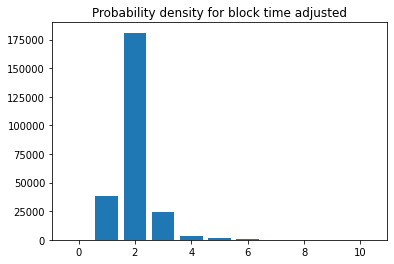

In [ ]:
## CDF & PDF plot for block time adjusted
block_time_cdf = cdf_plot(block, 'block_second_adj', title = 'Cumulative distribution for block time adjusted')
print(block_time_cdf.head(10))
plt.bar(block_time_cdf['block_second_adj'], block_time_cdf['count'])
plt.title('Probability density for block time adjusted')

<div class="markdown-google-sans">

## 2. Transaction Performance
 <h3> 2.1 Average TPS by Hour </h3>
</div>


The transaction per second (TPS) by block is calculated as `# of transactions per block / block time (adjusted)`, also taking into account of the missing blocks. The calculation is done at block level.

In order to transform TPS by block to TPS by hour, the block data is grouped by `timestamp_h` which is `block_timestamp` transformed into the cloest hour, and the average TPS by hour is calculated as the average TPS of all the blocks occured within the same hour.

Looking at data from 2022-06-20 to 2022-06-25, the average TPS by hour fluctuates around 3.2 transactions. The minimum TPS is 2 transactions whereas the maximum is around 7.3 transactions.

Note: the blank parts of the chart is due to blocks with 0 second block time. Because the timestamp data is only up to seconds not milliseconds, the difference between two blocks will be 0 if the block time between the two is less than 1 second. Therefore, TPS - calculated as number of transactions divided by block time will have a 0 denominator when block time is less than 1 second. That's the reason why the graph below cannot show these data points.

The average TPS by hour is: 3.210358434087264
The minimum TPS by hour is: 2.0588926174496645
The maximum TPS by hour is: 7.278136200716847


Text(0.5, 0, 'Timestamp in hour')

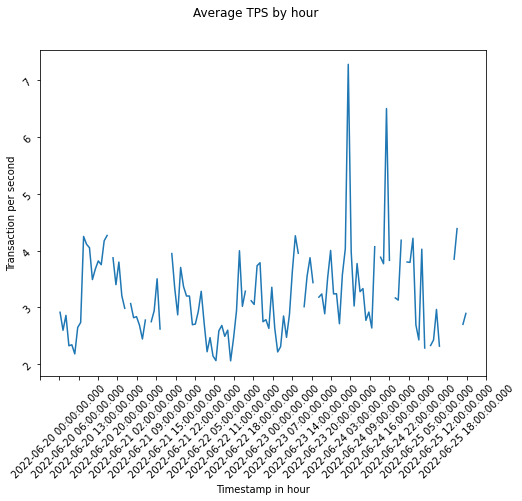

In [ ]:
## TPS by block
block['tps'] = block['tx_count']/block['block_second_adj']

## TPS by hour
tps_by_hour = pd.DataFrame(block.groupby(['timestamp_h'])['tps'].mean()).reset_index()

## Plot TPS by hour
print("The average TPS by hour is:", tps_by_hour['tps'].mean())
print("The minimum TPS by hour is:", tps_by_hour['tps'].min())
print("The maximum TPS by hour is:", tps_by_hour['tps'].max())

fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.plot('timestamp_h', 'tps', data=tps_by_hour)
fig.suptitle('Average TPS by hour')
ax.xaxis.set_major_locator(ticker.LinearLocator(24))
ax.tick_params(labelrotation=45)
ax.set_ylabel('Transaction per second')
ax.set_xlabel('Timestamp in hour')

The PDF plot for TPS shows the majority of the TPS is below 4 transactions per second. The CDF plot shows 88% of the blocks has a TPS less than or equal to 4.

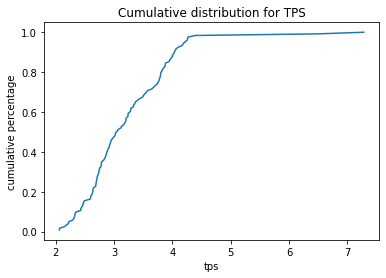

[Text(0.5, 1.0, 'Probability density for TPS')]

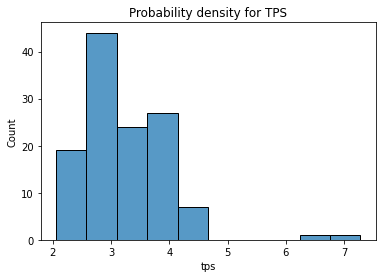

In [ ]:
## CDF & PDF plot for TPS
tps_cdf = cdf_plot(tps_by_hour, 'tps', title = 'Cumulative distribution for TPS')
sns.histplot(x=tps_by_hour["tps"], bins = 10).set(title='Probability density for TPS')


<div class="markdown-google-sans">

 <h3> 2.2 Transaction per Block </h3>
</div>

Looking at data from 2022-06-20 (block number `16259911`) to 2022-06-25 (block number `16511800`), the average transaction per block is around 5.7 transactions. The minimum transaction per block is 1 whereas the maximum is 144 transactions.

The average tx per block is: 5.721137059586064
The median tx per block is: 5
The minimum tx per block is: 1
The maximum tx per block is: 144


Text(0.5, 0, 'Block number')

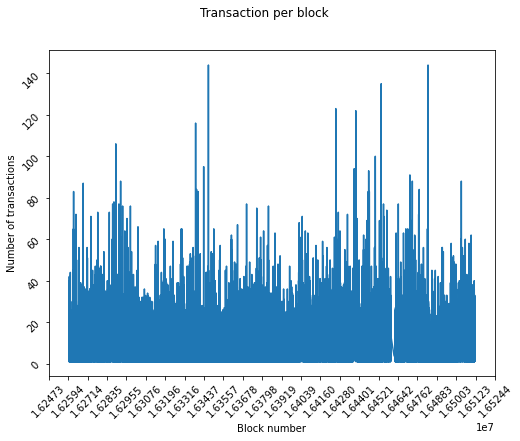

In [ ]:
## Load block level data joined with aggregated transaction level data
api_block = ['https://node-api.flipsidecrypto.com/api/v2/queries/daf47abc-d234-4e7b-8c35-b3b98bb67acf/data/latest',
            'https://node-api.flipsidecrypto.com/api/v2/queries/db5442ff-2503-4442-a803-6f4bdf00722f/data/latest',
             'https://node-api.flipsidecrypto.com/api/v2/queries/0d1db9f1-70a6-46d4-81cd-1aa950b59a91/data/latest']

block_tx = load_data_multiple(api_block)

## Plot tx per block
print("The average tx per block is:", block_tx['tx_count'].mean())
print("The median tx per block is:", statistics.median(block_tx['tx_count']))
print("The minimum tx per block is:", block_tx['tx_count'].min())
print("The maximum tx per block is:", block_tx['tx_count'].max())

fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.plot('block_number', 'tx_count', data=block_tx)
fig.suptitle('Transaction per block')
ax.xaxis.set_major_locator(ticker.LinearLocator(24))
ax.tick_params(labelrotation=45)
ax.set_ylabel('Number of transactions')
ax.set_xlabel('Block number')


The PDF plot for transaction per block shows the highest concentration is in transaction count below 10. Ranking the transaction count per block in ascending order, 90% of the blocks have less than 10 transactions per block.

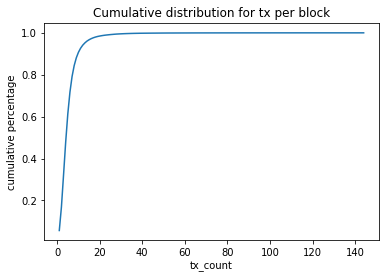

   tx_count  count  count_perc  cum_count  cum_count_perc
0         1  14154    0.056805      14154        0.056805
1         2  27903    0.111984      42057        0.168789
2         3  38192    0.153277      80249        0.322067
3         4  38967    0.156388     119216        0.478454
4         5  33581    0.134772     152797        0.613226
5         6  25829    0.103661     178626        0.716887
6         7  18609    0.074684     197235        0.791571
7         8  13061    0.052418     210296        0.843989
8         9   9208    0.036955     219504        0.880944
9        10   6556    0.026311     226060        0.907256


Text(0.5, 1.0, 'Probability density for for tx per block')

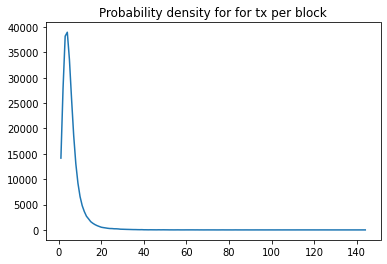

In [ ]:
## CDF plot for TPS
block_tx_cdf = cdf_plot(block_tx, 'tx_count', title = 'Cumulative distribution for tx per block')
print(block_tx_cdf.head(10))
plt.plot(block_tx_cdf['tx_count'], block_tx_cdf['count'])
plt.title('Probability density for for tx per block')

<div class="markdown-google-sans">

 <h3> 2.3 Transactions vs. Gas Used by Hour</h3>
</div>

When looking at the average transactions within an hour, the average number of transactions is highly correlated with the average gas used. The correlation between the two is 75%, the higher the average number of transactions, the higher the gas used. 

This is also the case for minimum transaction count and the minimum gas used within an hour over the same period of time. The correlation between the two is 98%. 

However, for maximum transaction count and the maximum gas used, this is no longer the case. The maximum number of transactions almost always corresponds to a high amount of gas used.

The Pearson correlation between average tx count and average gas used is: 0.748


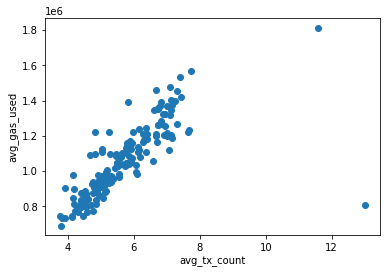

In [ ]:
## Load aggregated hourly block data
tx_by_hour = load_data('https://node-api.flipsidecrypto.com/api/v2/queries/32191a3f-e780-4952-ae51-40246b53ebab/data/latest')

## Calculate Pearson's correlation
corr, _ = pearsonr(tx_by_hour['avg_tx_count'], tx_by_hour['avg_gas_used'])
print('The Pearson correlation between average tx count and average gas used is: %.3f' % corr)

## Scatter plot
plt.scatter(tx_by_hour['avg_tx_count'], tx_by_hour['avg_gas_used'])
plt.xlabel('avg_tx_count')
plt.ylabel('avg_gas_used')
plt.show()

## Line plot
IFrame('https://app.flipsidecrypto.com/velocity/visuals/7bf7c1ba-85c0-4aff-9c51-c8461bc3266c/32191a3f-e780-4952-ae51-40246b53ebab', 800, 500)


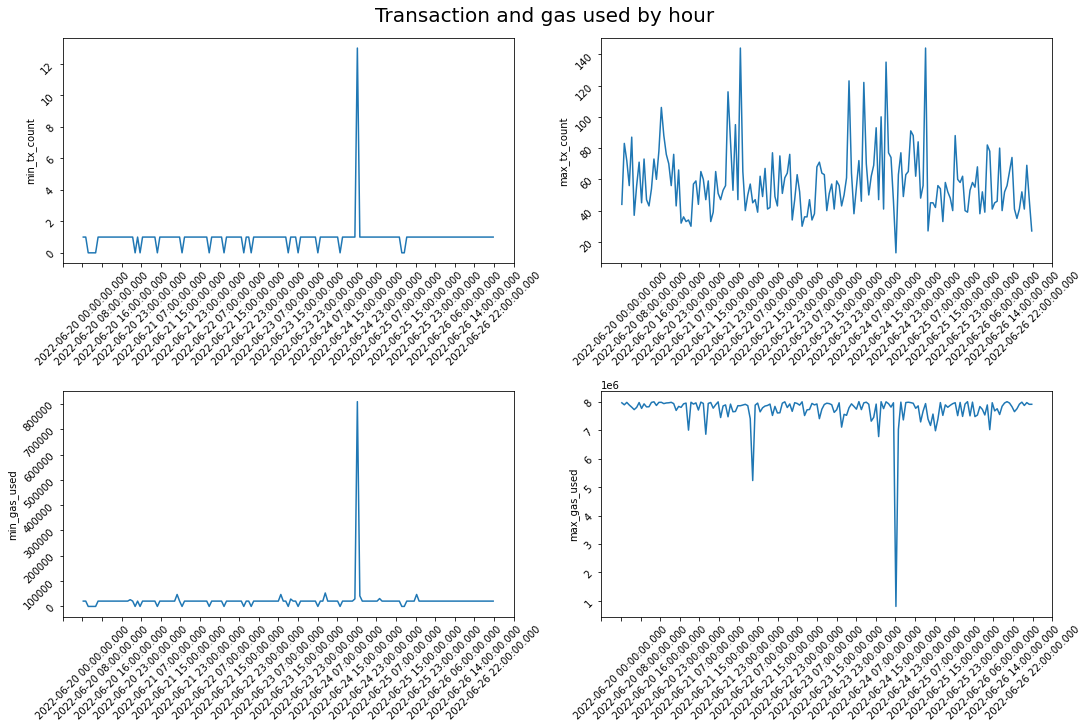

In [ ]:
## Minimum & maximum tx count & gas used by hour
item = [['min_tx_count', 'max_tx_count'], 
        ['min_gas_used', 'max_gas_used']]

subplot_multiple(tx_by_hour, row=2, col=2, row_size=15, col_size=10, day_interval=3, item_list=item, title='Transaction and gas used by hour')

The Pearson correlation between minimum tx count and gas used is: 0.976


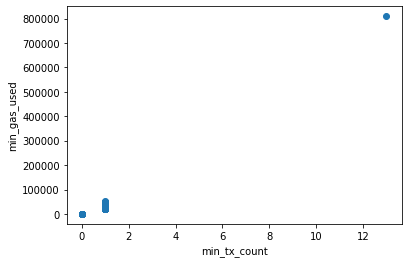

In [ ]:
## Calculate Pearson's correlation
corr, _ = pearsonr(tx_by_hour['min_tx_count'], tx_by_hour['min_gas_used'])
print('The Pearson correlation between minimum tx count and gas used is: %.3f' % corr)

## Scatter plot
plt.scatter(tx_by_hour['min_tx_count'], tx_by_hour['min_gas_used'])
plt.xlabel('min_tx_count')
plt.ylabel('min_gas_used')
plt.show()

## Line plot
IFrame('https://velocity-app.flipsidecrypto.com/velocity/visuals/befafe27-1d7d-42e4-81ca-0225bf21f116/32191a3f-e780-4952-ae51-40246b53ebab', 800, 500)

The Pearson correlation between maximum tx count and gas used is: 0.219


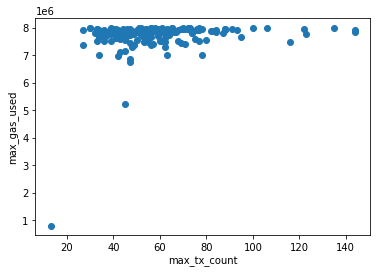

In [ ]:
## Calculate Pearson's correlation
corr, _ = pearsonr(tx_by_hour['max_tx_count'], tx_by_hour['max_gas_used'])
print('The Pearson correlation between maximum tx count and gas used is: %.3f' % corr)

## Scatter plot
plt.scatter(tx_by_hour['max_tx_count'], tx_by_hour['max_gas_used'])
plt.xlabel('max_tx_count')
plt.ylabel('max_gas_used')
plt.show()

## Line plot
IFrame('https://velocity-app.flipsidecrypto.com/velocity/visuals/4e931c6b-6c6e-4309-87d2-0f3a0e98b01d/32191a3f-e780-4952-ae51-40246b53ebab', 800, 500)

<div class="markdown-google-sans">

## 3. Gas Price & Fees
</div>

The data used in this section is sourced from the `avalanche.core.fact_transactions` table. The transaction level data is aggregated to block number and transaction status level by taking the average across all transactions within the block.


In [ ]:
## Load gas price data
api_gas_price = ['https://node-api.flipsidecrypto.com/api/v2/queries/890de58b-47e4-4e68-86c4-ef8158e74a9c/data/latest',
                 'https://node-api.flipsidecrypto.com/api/v2/queries/12337c53-5994-4e0d-b1f3-66d409ee8de4/data/latest',
                 'https://node-api.flipsidecrypto.com/api/v2/queries/f06b3782-1c7f-4b94-85bf-f2b546421d67/data/latest',
                 'https://node-api.flipsidecrypto.com/api/v2/queries/729fe148-6303-4ae4-8d9e-4883b444cc3a/data/latest']

gas_price = load_data_multiple(api_gas_price)
gas_price = gas_price.reset_index()
gas_price.head()

,index,block_number,status,tx_count,avg_gas_price,median_gas_price,avg_gas_used,median_gas_used,avg_tx_fee,median_tx_fee
0,0,16259911,SUCCESS,6,26.500000,25.75,110575.500000,101138.5,0.002974,0.002606
1,1,16259912,SUCCESS,7,28.514286,27.50,495988.428571,83997.0,0.013318,0.002375
2,2,16259913,SUCCESS,21,27.421429,26.50,145779.619048,78976.0,0.004045,0.002093
3,3,16259914,SUCCESS,19,26.144737,25.00,220319.894737,21004.0,0.005757,0.000788
4,4,16259915,SUCCESS,5,28.300000,30.00,77908.400000,42788.0,0.002312,0.001247


The average gas price at the block level over the period from 2022-06-20 to 2022-06-25 is 36.8; whereas the minimum and maximum gas price observed during the same period are 25 and 13309 respectively. The average gas price for successful transactions is lower than the failed ones.

The mean gas price is: 36.809775646917835
The minimum gas price is: 25.0
The maximum gas price is: 13309.220818878

The mean gas price for successfull tx is: 35.024099162412575
The minimum gas price for successfull tx is: 25.0
The maximum gas price for successfull tx is: 8239.858888889

The mean gas price for failed tx is: 44.769134504132126
The minimum gas price for failed tx is: 25.0
The maximum gas price for failed tx is: 13309.220818878


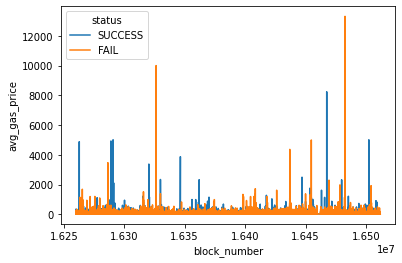

In [ ]:
## Gas price over time
print("The mean gas price is:", gas_price['avg_gas_price'].mean())
print("The minimum gas price is:", gas_price['avg_gas_price'].min())
print("The maximum gas price is:", gas_price['avg_gas_price'].max())
print("")
print("The mean gas price for successfull tx is:", gas_price[gas_price['status']=='SUCCESS']['avg_gas_price'].mean())
print("The minimum gas price for successfull tx is:", gas_price[gas_price['status']=='SUCCESS']['avg_gas_price'].min())
print("The maximum gas price for successfull tx is:", gas_price[gas_price['status']=='SUCCESS']['avg_gas_price'].max())
print("")
print("The mean gas price for failed tx is:", gas_price[gas_price['status']=='FAIL']['avg_gas_price'].mean())
print("The minimum gas price for failed tx is:", gas_price[gas_price['status']=='FAIL']['avg_gas_price'].min())
print("The maximum gas price for failed tx is:", gas_price[gas_price['status']=='FAIL']['avg_gas_price'].max())

sns.lineplot(data=gas_price, x="block_number", y="avg_gas_price", hue="status")

The average tx fee at the block level over the period from 2022-06-20 to 2022-06-25 is 0.007; whereas the minimum and maximum tx fee observed during the same period are 0.0005 and 4.5 respectively. The average tx fee for successful transactions is slightly higher than the failed ones.

The mean tx fee is: 0.006740915962137877
The minimum tx fee is: 0.000525
The maximum tx fee is: 4.477690288

The mean tx fee for successfull tx is: 0.006995996521908367
The minimum tx fee for successfull tx is: 0.000525
The maximum tx fee for successfull tx is: 2.2743955

The mean tx fee for failed tx is: 0.005603936374665211
The minimum tx fee for failed tx is: 0.0005399
The maximum tx fee for failed tx is: 4.477690288


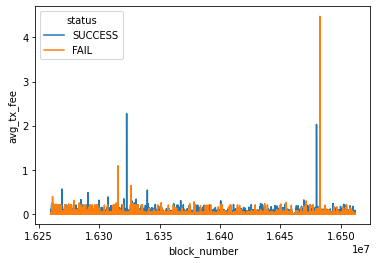

In [ ]:
## Tx fee over time
print("The mean tx fee is:", gas_price['avg_tx_fee'].mean())
print("The minimum tx fee is:", gas_price['avg_tx_fee'].min())
print("The maximum tx fee is:", gas_price['avg_tx_fee'].max())
print("")
print("The mean tx fee for successfull tx is:", gas_price[gas_price['status']=='SUCCESS']['avg_tx_fee'].mean())
print("The minimum tx fee for successfull tx is:", gas_price[gas_price['status']=='SUCCESS']['avg_tx_fee'].min())
print("The maximum tx fee for successfull tx is:", gas_price[gas_price['status']=='SUCCESS']['avg_tx_fee'].max())
print("")
print("The mean tx fee for failed tx is:", gas_price[gas_price['status']=='FAIL']['avg_tx_fee'].mean())
print("The minimum tx fee for failed tx is:", gas_price[gas_price['status']=='FAIL']['avg_tx_fee'].min())
print("The maximum tx fee for failed tx is:", gas_price[gas_price['status']=='FAIL']['avg_tx_fee'].max())


sns.lineplot(data=gas_price, x="block_number", y="avg_tx_fee", hue="status")

The pie charts below show more than 90% of the transactions on Avalanche are successful. 87% of the total gas is used for successful transactions and 85% of the fees paid are for successful transactions. There seems to be very little gas and fees wasted on failed transactions on Avalanche.

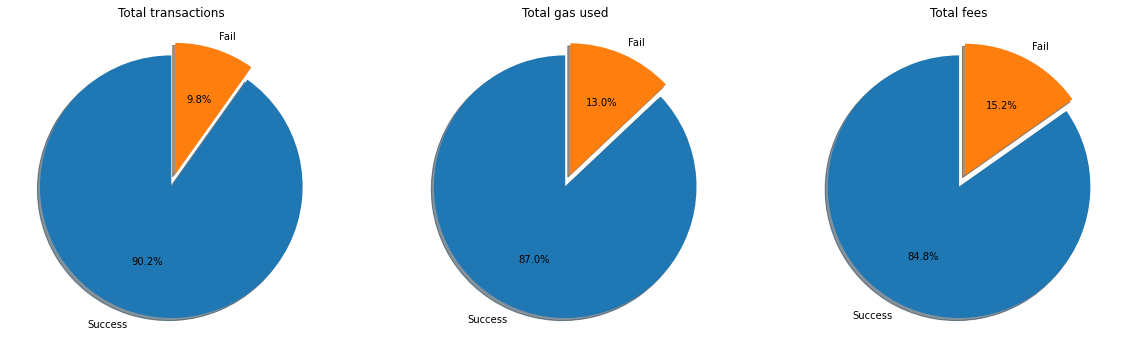

In [ ]:
## Pie chart for success vs. fail transaction
n_success = gas_price[gas_price.status == 'SUCCESS']['tx_count'].sum()
n_fail = gas_price[gas_price.status == 'FAIL']['tx_count'].sum()

gas_used_success = gas_price[gas_price.status == 'SUCCESS']['avg_gas_used'].sum()
gas_used_fail = gas_price[gas_price.status == 'FAIL']['avg_gas_used'].sum()

fee_success = gas_price[gas_price.status == 'SUCCESS']['avg_tx_fee'].sum()
fee_fail = gas_price[gas_price.status == 'FAIL']['avg_tx_fee'].sum()

labels = 'Success', 'Fail'
explode = (0, 0.1)
tx_sizes = [n_success, n_fail]
gu_sizes = [gas_used_success, gas_used_fail]
fee_sizes = [fee_success, fee_fail]

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10), sharey=True)
ax1.pie(tx_sizes, explode=explode, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
ax1.title.set_text('Total transactions')

ax2.pie(gu_sizes, explode=explode, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
ax2.title.set_text('Total gas used')

ax3.pie(fee_sizes, explode=explode, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
ax3.title.set_text('Total fees')

<div class="markdown-google-sans">

## 4. Event Analysis
</div>

The transaction event data is sourced from the `avalanche.core.fact_event_logs` table. The size of the entire data from 2022-06-20 to 2022-06-25 for by each event is too big to be fetched in one go from Flipside's database. The SQL code pages through the maximum 100,000 rows each time and the following code combine them together.

`Transfer` constitutes the most event types in a transaction with 47% of the total transactions, followed by `Approval` (12%), `Sync` (11%) and `Swap` (10%). 80% of the transactions belong to these four event types.

In [ ]:
## Load transaction event data
api_event = ['https://node-api.flipsidecrypto.com/api/v2/queries/e9930903-87e8-4199-970e-44ebe37eb311/data/latest',
             'https://node-api.flipsidecrypto.com/api/v2/queries/63375bf6-050a-462c-bc2c-24d5396a87d0/data/latest',
             'https://node-api.flipsidecrypto.com/api/v2/queries/fb2e5da9-4908-4820-8aba-d0ce6d4ba91f/data/latest',
             'https://node-api.flipsidecrypto.com/api/v2/queries/86449e93-3464-4ea0-97a9-40ccce7a81d8/data/latest',
             'https://node-api.flipsidecrypto.com/api/v2/queries/7796bdd1-6e60-4ace-8d1f-189ef064b715/data/latest',
             'https://node-api.flipsidecrypto.com/api/v2/queries/b2ed0fff-c5b8-49d8-8750-e45b2edf0b64/data/latest',
             'https://node-api.flipsidecrypto.com/api/v2/queries/816552a6-612e-4253-9faa-bd4aff693d9c/data/latest',
             'https://node-api.flipsidecrypto.com/api/v2/queries/a2d1774c-c5fb-4441-83ae-968c507eb01b/data/latest',
             'https://node-api.flipsidecrypto.com/api/v2/queries/3cb6e4f1-2863-43c0-b919-ce1e4669c4de/data/latest',
             'https://node-api.flipsidecrypto.com/api/v2/queries/4fa953bb-3ae0-4e82-9d1f-4f3c4597cc4b/data/latest',
             'https://node-api.flipsidecrypto.com/api/v2/queries/004405f7-8653-4eac-9085-07f20de96bec/data/latest',
             'https://node-api.flipsidecrypto.com/api/v2/queries/2f0a8c28-dc6c-4a0d-9da5-b7d292bb246a/data/latest',
             'https://node-api.flipsidecrypto.com/api/v2/queries/96774739-aad5-4d36-80ec-9614e19d973f/data/latest',
             'https://node-api.flipsidecrypto.com/api/v2/queries/af4ad0c3-1938-4972-b825-ee254b48a722/data/latest',
             'https://node-api.flipsidecrypto.com/api/v2/queries/5bcc0cc3-ac0c-4207-99d7-d2d81b8dd232/data/latest',
             'https://node-api.flipsidecrypto.com/api/v2/queries/797a3541-759f-4e31-9dbd-91ed4431a4e1/data/latest',
             'https://node-api.flipsidecrypto.com/api/v2/queries/336fb511-9778-4663-9de4-778be64783ea/data/latest']

event_block = load_data_multiple(api_event)
event_block = event_block.reset_index()

,index,block_number,event_name,tx_count
0,0,16259911,Approval,1
1,1,16259911,Staked,1
2,2,16259911,Swap,1
3,3,16259911,Sync,1
4,4,16259911,Transfer,3


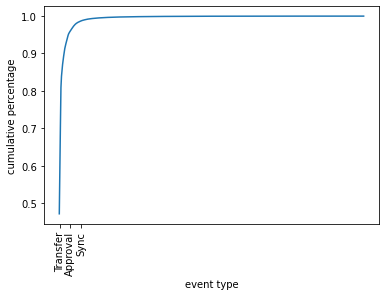

,index,event_name,tx_count,count_perc,cum_count,cum_count_perc
0,474,Transfer,2226352,0.470905,2226352,0.470905
1,21,Approval,571252,0.120828,2797604,0.591732
2,435,Sync,531534,0.112427,3329138,0.704159
3,425,Swap,494570,0.104608,3823708,0.808768
4,98,Deposit,144217,0.030504,3967925,0.839272


In [ ]:
## Plot event type
event_agg = pd.DataFrame(event_block.groupby('event_name')['tx_count'].sum()).reset_index().rename(columns={0:"count"})
event_agg = event_agg.sort_values(by=['tx_count'], ascending = False)
event_agg['count_perc'] = event_agg['tx_count']/event_agg['tx_count'].sum()
event_agg['cum_count'] = event_agg['tx_count'].cumsum()
event_agg['cum_count_perc'] = event_agg['cum_count']/event_agg['tx_count'].sum()
event_agg = event_agg.reset_index()

plt.plot(event_agg['event_name'], event_agg['cum_count_perc'])
plt.xticks([1,20,40],['Transfer','Approval','Sync'], rotation = 90)
plt.xlabel("event type")
plt.ylabel("cumulative percentage")
plt.show()

event_agg.head(5)

Text(0.5, 1.0, 'Transaction event type')

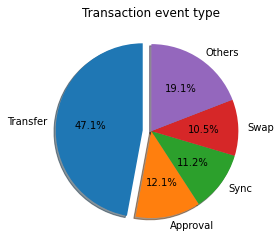

In [ ]:
## Pie chart
n_transfer = event_agg[event_agg.event_name == 'Transfer']['tx_count'].sum()
n_approval = event_agg[event_agg.event_name == 'Approval']['tx_count'].sum()
n_sync = event_agg[event_agg.event_name == 'Sync']['tx_count'].sum()
n_swap = event_agg[event_agg.event_name == 'Swap']['tx_count'].sum()
n_other = event_agg[~event_agg.event_name.isin(['Transfer','Approval','Sync','Swap'])]['tx_count'].sum()

labels = 'Transfer', 'Approval', 'Sync', 'Swap', 'Others'
explode = (0.1, 0, 0, 0, 0)
event_sizes = [n_transfer, n_approval, n_sync, n_swap, n_other]

plt.pie(event_sizes, labels=labels, explode=explode, autopct='%1.1f%%',shadow=True, startangle=90)
plt.title('Transaction event type')


<div class="markdown-google-sans">

## 5. Predicting Transaction Status
</div>



The transaction level data used in the gas price and fees analysis in section 3 has a binary transaction status of SUCCESS and FAIL. Using the transaction variables i.e. transaction count, gas price, gas used, transaction fee as shown below, a model can be built to predict the transaction status.

In [ ]:
gas_price.head()

,index,block_number,status,tx_count,avg_gas_price,median_gas_price,avg_gas_used,median_gas_used,avg_tx_fee,median_tx_fee
0,0,16259911,SUCCESS,6,26.500000,25.75,110575.500000,101138.5,0.002974,0.002606
1,1,16259912,SUCCESS,7,28.514286,27.50,495988.428571,83997.0,0.013318,0.002375
2,2,16259913,SUCCESS,21,27.421429,26.50,145779.619048,78976.0,0.004045,0.002093
3,3,16259914,SUCCESS,19,26.144737,25.00,220319.894737,21004.0,0.005757,0.000788
4,4,16259915,SUCCESS,5,28.300000,30.00,77908.400000,42788.0,0.002312,0.001247


Since all the four available variables seem skewed by outliers as shown in the historgrams and the box-plots below, log transformation is applied to make them more comparable and easier to interpret in a chart.

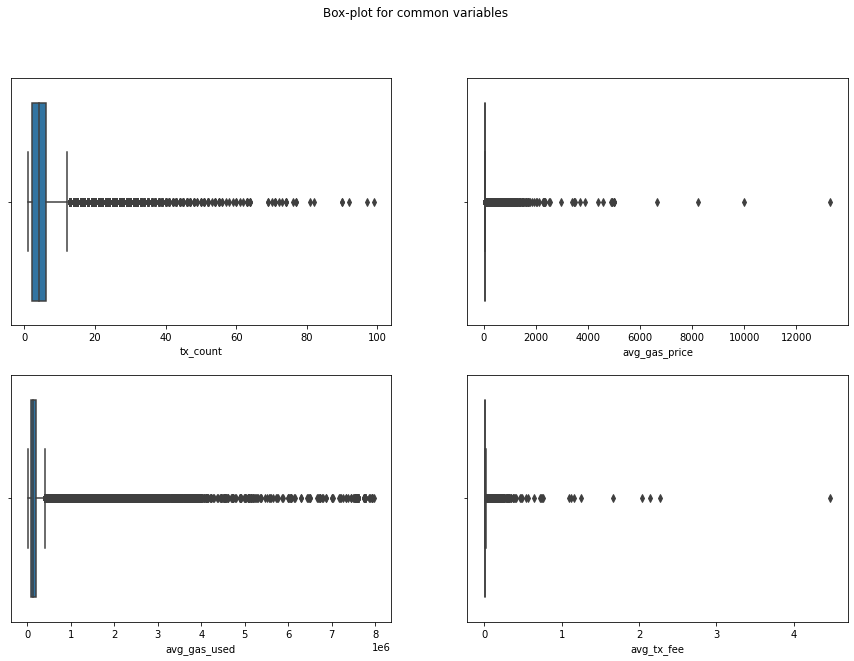

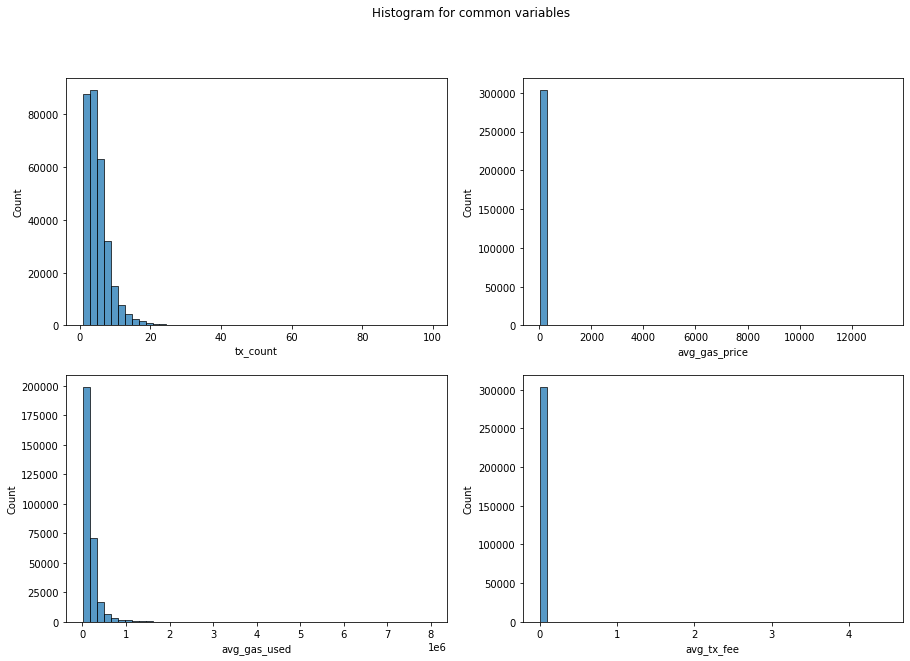

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharey=False)
fig.suptitle('Box-plot for common variables')

sns.boxplot(ax=axes[0,0], x=gas_price['tx_count'], showfliers = True)
sns.boxplot(ax=axes[0,1], x=gas_price['avg_gas_price'], showfliers = True)
sns.boxplot(ax=axes[1,0], x=gas_price['avg_gas_used'], showfliers = True)
sns.boxplot(ax=axes[1,1], x=gas_price['avg_tx_fee'], showfliers = True)

## Histogram for the four common variables
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharey=False)
fig.suptitle('Histogram for common variables')

sns.histplot(ax=axes[0,0], x=gas_price["tx_count"], bins = 50)
sns.histplot(ax=axes[0,1], x=gas_price["avg_gas_price"], bins = 50)
sns.histplot(ax=axes[1,0], x=gas_price["avg_gas_used"], bins = 50)
sns.histplot(ax=axes[1,1], x=gas_price["avg_tx_fee"], bins = 50)

The box plots below show the variables become less skewed after the log transformation. The correlation matrix shows tx fee and gas used have a high correlation (89%).

In [ ]:
## Preprocess through log transformation
x_log = gas_price[['tx_count','avg_gas_price','avg_gas_used','avg_tx_fee']]
x_log = x_log.replace(0, 0.0001)
x_log = np.log(x_log)
x_log['status'] = gas_price['status']
x_log['status_dummy'] = np.where(x_log['status']=='SUCCESS', 1, 0)


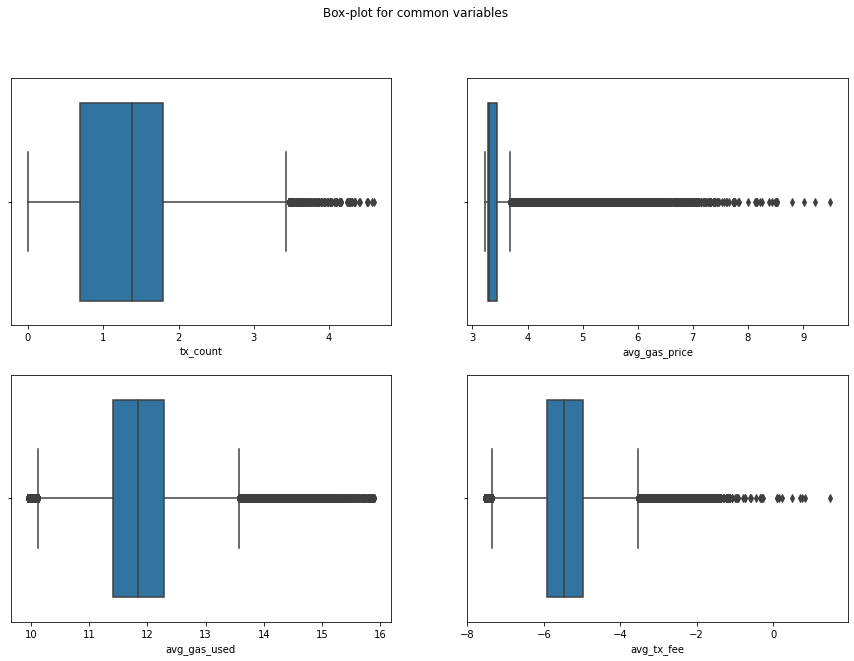

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharey=False)
fig.suptitle('Box-plot for common variables')

sns.boxplot(ax=axes[0,0], x=x_log['tx_count'], showfliers = True)
sns.boxplot(ax=axes[0,1], x=x_log['avg_gas_price'], showfliers = True)
sns.boxplot(ax=axes[1,0], x=x_log['avg_gas_used'], showfliers = True)
sns.boxplot(ax=axes[1,1], x=x_log['avg_tx_fee'], showfliers = True)


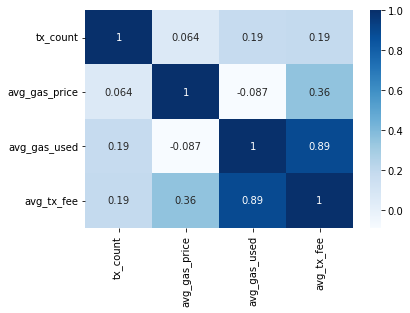

In [ ]:
## Correlation plot
sns.heatmap(x_log.drop(['status_dummy'], axis=1).corr(), cmap="Blues", annot=True)

To further investigate the correlation between each variable pair and their importance in distinguishing successful and failed transactions, scatter plots are shown below using the color difference - success in yellow and fail in purple.

Although the charts do not sure clear separations of the color for success and fail transactions, it's easy to use that the failed transactions seem to concentrate in the regions of low gas used and low tx fee.

Text(0, 0.5, 'avg_gas_price')

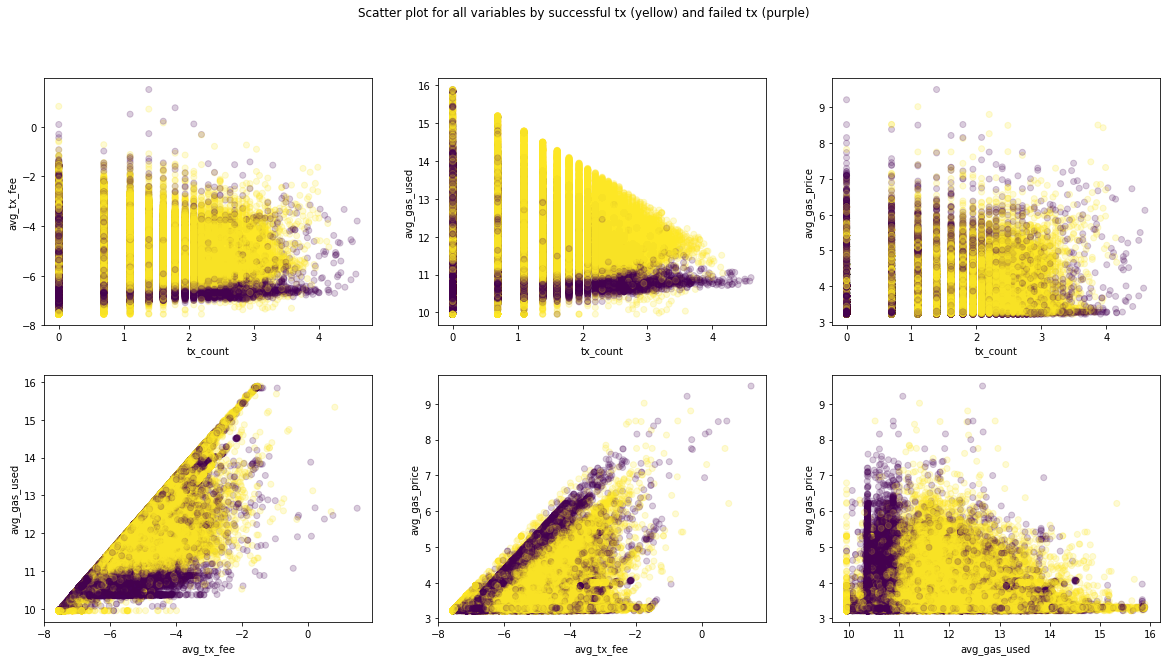

In [ ]:
## Scatter correlation plot (purple-0 Fail, yellow-1 Success)
fig, ax = plt.subplots(2, 3, figsize=(20, 10), sharey=False)
fig.suptitle('Scatter plot for all variables by successful tx (yellow) and failed tx (purple)')

ax[0,0].scatter(x=x_log['tx_count'],y=x_log['avg_tx_fee'], c=x_log['status_dummy'], label=np.unique(x_log['status_dummy']), alpha=0.2)
ax[0,0].set_xlabel('tx_count')
ax[0,0].set_ylabel('avg_tx_fee')
    
ax[0,1].scatter(x=x_log['tx_count'],y=x_log['avg_gas_used'], c=x_log['status_dummy'], label=np.unique(x_log['status_dummy']), alpha=0.2)
ax[0,1].set_xlabel('tx_count')
ax[0,1].set_ylabel('avg_gas_used')

ax[0,2].scatter(x=x_log['tx_count'],y=x_log['avg_gas_price'], c=x_log['status_dummy'], label=np.unique(x_log['status_dummy']), alpha=0.2)
ax[0,2].set_xlabel('tx_count')
ax[0,2].set_ylabel('avg_gas_price')

ax[1,0].scatter(x=x_log['avg_tx_fee'],y=x_log['avg_gas_used'], c=x_log['status_dummy'], label=np.unique(x_log['status_dummy']), alpha=0.2)
ax[1,0].set_xlabel('avg_tx_fee')
ax[1,0].set_ylabel('avg_gas_used')

ax[1,1].scatter(x=x_log['avg_tx_fee'],y=x_log['avg_gas_price'], c=x_log['status_dummy'], label=np.unique(x_log['status_dummy']), alpha=0.2)
ax[1,1].set_xlabel('avg_tx_fee')
ax[1,1].set_ylabel('avg_gas_price')

ax[1,2].scatter(x=x_log['avg_gas_used'],y=x_log['avg_gas_price'], c=x_log['status_dummy'], label=np.unique(x_log['status_dummy']), alpha=0.2)
ax[1,2].set_xlabel('avg_gas_used')
ax[1,2].set_ylabel('avg_gas_price')

<div class="markdown-google-sans">

## **Logistic Regression**
</div>

[Logistic Regression](https://en.wikipedia.org/wiki/Logistic_regression) is one of the most commonly used models for predicting binary events. Here, two models are run - one with transformed variables (weight-of-evidence [WOE](https://documentation.sas.com/doc/en/vdmmlcdc/8.1/casstat/viyastat_binning_details02.htm) transformation); one with the original variables.

The model performance is slightly better with the original variables, with an R-squared of 16.85% compared to 16.11% with the WOE transfomed variables. The overall model performance is not ideal, with only 52% accuracy score and a large percentage of mis-classifying successful transactions into failed ones according to the confusion matrix.

The conclusion that can be made is that four variables available are far from enough to predict the transaction status. More additional variables containing more information will be needed to improve the prediction.

In [ ]:
## WOE binning ('good' - Success, 'bad' - Fail)
gas_price['status_dummy'] = np.where(gas_price['status']=='SUCCESS', 1, 0)
binning_gasprice = woeBinningPandas.woe_binning(gas_price, "status_dummy", "avg_gas_price", min_perc_total=0.05, min_perc_class=0, stop_limit=0.1, abbrev_fact_levels=50, event_class='FAIL')
binning_gasused = woeBinningPandas.woe_binning(gas_price,"status_dummy", "avg_gas_used", min_perc_total=0.05, min_perc_class=0, stop_limit=0.1, abbrev_fact_levels=50, event_class='FAIL')
binning_profit= woeBinningPandas.woe_binning(gas_price,"status_dummy", "avg_tx_fee", min_perc_total=0.05, min_perc_class=0, stop_limit=0.1, abbrev_fact_levels=50, event_class='FAIL')
binning_time= woeBinningPandas.woe_binning(gas_price,"status_dummy", "tx_count", min_perc_total=0.05, min_perc_class=0, stop_limit=0.1, abbrev_fact_levels=50, event_class='FAIL')

## The higher WOE, the higher % Success
gas_price['woe_gas_price'] = pd.cut(gas_price['avg_gas_price'], right=True, bins=binning_gasprice['cutpoints_final'], labels=binning_gasprice['woe'][:len(binning_gasprice)-1])
gas_price['woe_gas_used'] = pd.cut(gas_price['avg_gas_used'], right=True, bins=binning_gasused['cutpoints_final'], labels=binning_gasused['woe'][:len(binning_gasused)-1])
gas_price['woe_tx_fee'] = pd.cut(gas_price['avg_tx_fee'], right=True, bins=binning_profit['cutpoints_final'], labels=binning_profit['woe'][:len(binning_profit)-1])
gas_price['woe_tx_count'] = np.where(gas_price['tx_count']<=25, binning_time['woe'][0], binning_time['woe'][1])

## Create data for modeling
x_train_woe = gas_price[['woe_gas_price','woe_gas_used','woe_tx_fee','woe_tx_count']]
x_train = gas_price[['avg_gas_price','avg_gas_used','avg_tx_fee','tx_count']]
y_train = gas_price[['status_dummy']]

In [ ]:
## Run Logistic regression with transformed variables
logreg_stat = sm.Logit(y_train, x_train_woe).fit()
logreg_stat.params
logreg_stat.summary()


Optimization terminated successfully.
         Current function value: 0.399532
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           status_dummy   No. Observations:               304623
Model:                          Logit   Df Residuals:                   304619
Method:                           MLE   Df Model:                            3
Date:                Mon, 27 Jun 2022   Pseudo R-squ.:                  0.1611
Time:                        19:26:26   Log-Likelihood:            -1.2171e+05
converged:                       True   LL-Null:                   -1.4508e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
woe_gas_price     0.0112      0.000     86.300      0.000       0.011       0.011
woe_gas_used     -0.0004      0.000     -1.291      0.197      -0.001       0.000
woe_tx_fee        0.0103   6.26e-05    164.923      0.000       0.010       0.010
woe_tx_count     -0.0061      0.000    -13.572      0.000      -0.007      -0.005
=================================================================================
"""

In [ ]:
## Run Logistic regression
logreg_final = sm.Logit(y_train, x_train).fit()
logreg_final.params
logreg_final.summary()

Optimization terminated successfully.
         Current function value: 0.396041
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           status_dummy   No. Observations:               304623
Model:                          Logit   Df Residuals:                   304619
Method:                           MLE   Df Model:                            3
Date:                Mon, 27 Jun 2022   Pseudo R-squ.:                  0.1685
Time:                        20:27:20   Log-Likelihood:            -1.2064e+05
converged:                       True   LL-Null:                   -1.4508e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
avg_gas_price    -0.0090      0.000    -50.001      0.000      -0.009      -0.009
avg_gas_used    7.77e-07   3.93e-08     19.778      0.000       7e-07    8.54e-07
avg_tx_fee       25.0132      1.016     24.615      0.000      23.022      27.005
tx_count          0.4424      0.002    187.708      0.000       0.438       0.447
=================================================================================
"""

Balanced Accuracy Score:  0.52
Log Loss:  6.16
Precision:  0.8
Recall:  0.82
F-score:  0.75
None


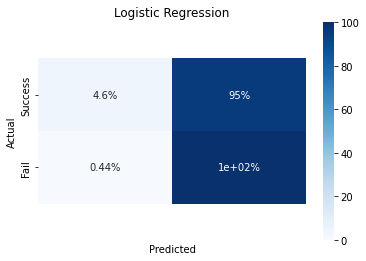

In [ ]:
## Tx status prediction
gas_price['status_predict'] = logreg_final.predict(x_train)
gas_price['status_predict'] = pd.DataFrame(list(map(round, gas_price['status_predict'] )))

## Performance
lr_train_eval = model_performance(y_train, gas_price['status_predict'])  
print(lr_train_eval)
plot_confusion_matrix(y_train, gas_price['status_predict'], class_name=['Success','Fail'],
                      title = 'Logistic Regression'
)